# Load Data

In [1]:
import json
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
from scipy.linalg import inv
from torch.optim import Adam

In [2]:
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]


# Encode Labels

In [3]:
label_encoder = LabelEncoder()
# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)

# Tokenize our sentences and create Dataloaders

In [4]:
pretrained_model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
transformer_model = AutoModel.from_pretrained(pretrained_model_name)

class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create the dataset
max_length = 37 
train_dataset = TextDataset(train_sentences, encoded_train_labels, tokenizer, max_length)
val_dataset = TextDataset(val_sentences, encoded_val_labels, tokenizer, max_length)

# Define functions to encode our sentences

In [5]:
transformer_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(device)
def encode_sentences(model, sentences):
    sentence_embeddings = []

    for sentence in sentences:
        encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}  # Move input to GPU if available
        with torch.no_grad():
            model_output = model(**encoded_input)

        pooled_output = model_output.last_hidden_state.mean(dim=1)
        sentence_embeddings.append(pooled_output.cpu().numpy())

    sentence_embeddings_np = np.concatenate(sentence_embeddings, axis=0)
    return sentence_embeddings_np

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Define our model

In [6]:
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, transformer_model):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model

        # Encoder layers
        self.encoder1 = nn.Linear(768, 512)
        self.encoder2 = nn.Linear(512, 256)
        self.encoder3 = nn.Linear(256, 128)

        # Decoder layers
        self.decoder1 = nn.Linear(128, 256)
        self.decoder2 = nn.Linear(256, 512)
        self.decoder3 = nn.Linear(512, 768)

    def forward(self, input_ids, attention_mask):
        # Transformer model output
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        original_embeddings = transformer_output.last_hidden_state.max(dim=1).values

        # Autoencoder forward pass
        x = nn.functional.relu(self.encoder1(original_embeddings))
        x = nn.functional.relu(self.encoder2(x))
        x = nn.functional.relu(self.encoder3(x))
        x = nn.functional.relu(self.decoder1(x))
        x = nn.functional.relu(self.decoder2(x))
        reconstructed_embeddings = self.decoder3(x)

        return original_embeddings, reconstructed_embeddings


# Define Reconstruction Loss

In [7]:
class ReconstructionLoss(nn.Module):
    def __init__(self):
        super(ReconstructionLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, original_embeddings, reconstructed_embeddings):
        return self.mse_loss(original_embeddings, reconstructed_embeddings)

In [8]:
loss_function = ReconstructionLoss()

# Initiallize everything else we needed

In [21]:
pretrained_model_name = "distilroberta-base"
unique_intents = list(set(train_labels)) 
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
transformer_model.to(device)
model = TextClassifier(transformer_model)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
training_losses = []
validation_losses = []
batch_size= 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [22]:
num_epochs = 50

# Training Loop!!!

In [23]:
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()  # Zero the gradients
        original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
        loss = loss_function(original_embeddings, reconstructed_embeddings)
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss) 

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
            loss = loss_function(original_embeddings, reconstructed_embeddings)  # Compute loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model
        torch.save(model, 'best_autoencoder_model.pth')
        print(f"Epoch {epoch+1}/{num_epochs}: Lower validation loss found. Model saved.")
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.5e}, Validation Loss: {avg_val_loss:.5e}")

Epoch 1/50: Lower validation loss found. Model saved.
Epoch 1/50, Training Loss: 8.45015e-03, Validation Loss: 2.03758e-01
Epoch 2/50: Lower validation loss found. Model saved.
Epoch 2/50, Training Loss: 1.47280e-04, Validation Loss: 1.65491e-01
Epoch 3/50: Lower validation loss found. Model saved.
Epoch 3/50, Training Loss: 1.25005e-04, Validation Loss: 1.14246e-01
Epoch 4/50: Lower validation loss found. Model saved.
Epoch 4/50, Training Loss: 9.95899e-05, Validation Loss: 8.81567e-02
Epoch 5/50: Lower validation loss found. Model saved.
Epoch 5/50, Training Loss: 8.40973e-05, Validation Loss: 6.81393e-02
Epoch 6/50: Lower validation loss found. Model saved.
Epoch 6/50, Training Loss: 7.07286e-05, Validation Loss: 5.16340e-02
Epoch 7/50: Lower validation loss found. Model saved.
Epoch 7/50, Training Loss: 5.35036e-05, Validation Loss: 4.21604e-02
Epoch 8/50: Lower validation loss found. Model saved.
Epoch 8/50, Training Loss: 4.49708e-05, Validation Loss: 3.32764e-02
Epoch 9/50: Lowe

# Calculate means and covariance matrix

In [9]:
fine_model = torch.load("best_autoencoder_model.pth")
fine_model.eval()  # Put the model in evaluation mode
fine_model = fine_model.to(device)

In [10]:
def encode_sentences(model, sentences):
    # the mode here is TextClassifier

    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt', max_length=50)
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    with torch.no_grad():
        model.eval()  # Ensure the model is in evaluation mode
        original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
    return reconstructed_embeddings.cpu().numpy()

In [11]:
train_embeddings = encode_sentences(fine_model, train_sentences)
val_embeddings = encode_sentences(fine_model, val_sentences)
test_embeddings = encode_sentences(fine_model, test_sentences)
oos_train_embeddings = encode_sentences(fine_model, oos_train_sentences)
oos_val_embeddings = encode_sentences(fine_model, oos_val_sentences)
oos_test_embeddings = encode_sentences(fine_model, oos_test_sentences)

In [12]:
intent_means = {}
for encoded_label in np.unique(encoded_train_labels):
    # Find indices where the encoded label matches
    indices = np.where(encoded_train_labels == encoded_label)[0]
    
    # Calculate the mean embedding for the current intent
    intent_embeddings = train_embeddings[indices]
    intent_mean = np.mean(intent_embeddings, axis=0)
    
    # Use the encoded label as the dictionary key
    intent_means[encoded_label] = intent_mean

In [13]:
covariance = np.cov(train_embeddings, rowvar=False)
cov_inverse = inv(covariance)

In [14]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from scipy.spatial import distance
from sklearn.metrics import average_precision_score

In [15]:
def min_mahalanobis_for_sample(sample, intent_means, cov_inverse):
    distances = [distance.mahalanobis(sample, mean, cov_inverse) for mean in intent_means.values()]
    return min(distances)

In [16]:
# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

# Combine the scores
y_scores = test_scores + oos_test_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr


0.20411546110192952

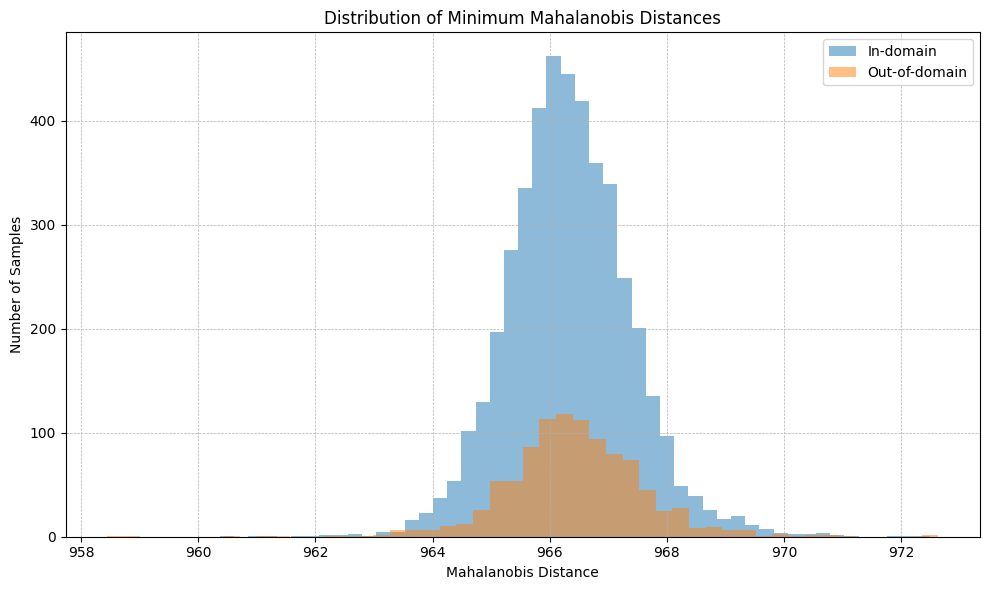

In [17]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()
